# 第14章：AutoML 与模型生命周期（可运行示例，**不使用 try/except**）

本Notebook覆盖：数据管道、简易实验记录、简化AutoML搜索（网格）、交叉验证、漂移检测（KS与PSI）、再训练编排与A/B测试。

中文字体启用： SimHei


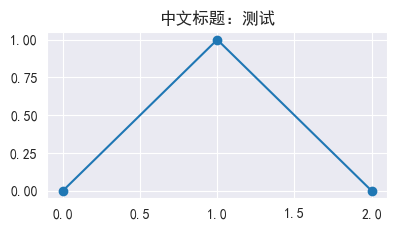

In [1]:

# ✓ Matplotlib 中文字体（无网络、不捕获异常）：仅在本机已有中文字体时启用
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

preferred = [
    "SimHei", "Microsoft YaHei", "PingFang SC", "Hiragino Sans GB",
    "Source Han Sans CN", "Source Han Sans SC", "Noto Sans CJK SC",
    "Noto Sans SC", "WenQuanYi Zen Hei", "Sarasa Gothic SC"
]
available = set(f.name for f in fm.fontManager.ttflist)
picked = ""
for name in preferred:
    if name in available:
        picked = name
        break

if picked:
    matplotlib.rcParams['font.sans-serif'] = [picked]
matplotlib.rcParams['axes.unicode_minus'] = False
print("中文字体启用：", picked if picked else "（未配置中文字体，使用默认）")

# 小测试
plt.figure(figsize=(4,2.4))
plt.title("中文标题：测试")
plt.plot([0,1,2],[0,1,0], "o-")
plt.tight_layout(); plt.show()


## 1. 数据管道：自定义 `Dataset` 与 `DataLoader`

In [3]:

import torch
from torch.utils.data import Dataset, DataLoader

class EconomicDataset(Dataset):
    def __init__(self, raw_data):
        self.X, self.y = [], []
        for r in raw_data:
            x = torch.tensor([r['gdp'], r['inflation'], r['unemployment']], dtype=torch.float32)
            y = torch.tensor(r['credit_risk'], dtype=torch.float32)  # 二分类标签 0/1
            self.X.append(x); self.y.append(y)
        self.X = torch.stack(self.X, dim=0)
        self.y = torch.stack(self.y, dim=0)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

raw_data = [
    {'gdp': 2.5, 'inflation': 1.7, 'unemployment': 5.2, 'credit_risk': 0},
    {'gdp': 1.8, 'inflation': 2.1, 'unemployment': 6.0, 'credit_risk': 1},
    {'gdp': 3.1, 'inflation': 1.3, 'unemployment': 4.8, 'credit_risk': 0},
    {'gdp': 0.9, 'inflation': 2.5, 'unemployment': 7.1, 'credit_risk': 1},
]

dataset = EconomicDataset(raw_data)
loader = DataLoader(dataset, batch_size=2, shuffle=True)
for xb, yb in loader:
    print("batch X:", xb, "\n batch y:", yb)
    break


batch X: tensor([[2.5000, 1.7000, 5.2000],
        [0.9000, 2.5000, 7.1000]]) 
 batch y: tensor([0., 1.])


## 2. 简易实验追踪（以字典与打印代替外部平台）

In [4]:

import time, json
exp_log = {"experiment": "AutoML_Econ_Mock", "runs": []}

def log_run(params, metrics):
    exp_log["runs"].append({"time": time.strftime("%Y-%m-%d %H:%M:%S"),
                            "params": params, "metrics": metrics})
    print("记录：", {"params": params, "metrics": metrics})

# 示例
log_run({"lr": 0.01, "epochs": 5}, {"val_loss": 0.123})
print("当前实验日志：\n", json.dumps(exp_log, ensure_ascii=False, indent=2))


记录： {'params': {'lr': 0.01, 'epochs': 5}, 'metrics': {'val_loss': 0.123}}
当前实验日志：
 {
  "experiment": "AutoML_Econ_Mock",
  "runs": [
    {
      "time": "2025-11-27 20:16:03",
      "params": {
        "lr": 0.01,
        "epochs": 5
      },
      "metrics": {
        "val_loss": 0.123
      }
    }
  ]
}


## 3. 简化版特征存储（线上/线下概念示例）

In [5]:

class SimpleFeatureStore:
    def __init__(self):
        self.offline = {}
        self.online = {}
    def materialize(self, name, series):
        self.offline[name] = list(series)
        self.online[name]  = series[-1]
    def get_offline(self, name):
        return self.offline.get(name, [])
    def get_online(self, name):
        return self.online.get(name, None)

store = SimpleFeatureStore()
store.materialize('avg_monthly_spend', [1000, 1200, 1100, 1300])
print("offline:", store.get_offline('avg_monthly_spend'))
print("online_latest:", store.get_online('avg_monthly_spend'))


offline: [1000, 1200, 1100, 1300]
online_latest: 1300


## 4. 简化 AutoML：小网格搜索（PyTorch MLP）

In [6]:

import numpy as np, torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 合成表格数据（二分类）
rng = np.random.RandomState(7)
X = rng.randn(2000, 20).astype(np.float32)
y = (X[:, :5].sum(axis=1) + rng.randn(2000)*0.5 > 0).astype(np.int64)

X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
train_dl = DataLoader(TensorDataset(torch.tensor(X_tr), torch.tensor(y_tr)), batch_size=64, shuffle=True)
val_dl   = DataLoader(TensorDataset(torch.tensor(X_va), torch.tensor(y_va)), batch_size=256)

class MLP(nn.Module):
    def __init__(self, in_dim, h, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(h, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze()

def train_eval(h, dropout, lr, epochs=10):
    model = MLP(X.shape[1], h, dropout)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    for _ in range(epochs):
        model.train()
        for xb, yb in train_dl:
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb.float())
            loss.backward(); opt.step()
    # 验证
    model.eval()
    preds, tars = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            p = (torch.sigmoid(model(xb)) > 0.5).int()
            preds.extend(p.tolist()); tars.extend(yb.tolist())
    acc = accuracy_score(tars, preds)
    return acc, model

grid = {
    "h": [32, 64],
    "dropout": [0.0, 0.1],
    "lr": [1e-3, 5e-4]
}

best = {"acc": -1.0, "params": None, "model": None}
for h in grid["h"]:
    for d in grid["dropout"]:
        for lr in grid["lr"]:
            acc, m = train_eval(h, d, lr)
            log_run({"h": h, "dropout": d, "lr": lr}, {"val_acc": acc})
            if acc > best["acc"]:
                best = {"acc": acc, "params": {"h": h, "dropout": d, "lr": lr}, "model": m}

print("最佳配置：", best["params"], " 验证准确率：", round(best["acc"], 4))
best_model = best["model"]


记录： {'params': {'h': 32, 'dropout': 0.0, 'lr': 0.001}, 'metrics': {'val_acc': 0.9}}
记录： {'params': {'h': 32, 'dropout': 0.0, 'lr': 0.0005}, 'metrics': {'val_acc': 0.8483333333333334}}
记录： {'params': {'h': 32, 'dropout': 0.1, 'lr': 0.001}, 'metrics': {'val_acc': 0.92}}
记录： {'params': {'h': 32, 'dropout': 0.1, 'lr': 0.0005}, 'metrics': {'val_acc': 0.8566666666666667}}
记录： {'params': {'h': 64, 'dropout': 0.0, 'lr': 0.001}, 'metrics': {'val_acc': 0.9166666666666666}}
记录： {'params': {'h': 64, 'dropout': 0.0, 'lr': 0.0005}, 'metrics': {'val_acc': 0.905}}
记录： {'params': {'h': 64, 'dropout': 0.1, 'lr': 0.001}, 'metrics': {'val_acc': 0.9133333333333333}}
记录： {'params': {'h': 64, 'dropout': 0.1, 'lr': 0.0005}, 'metrics': {'val_acc': 0.8983333333333333}}
最佳配置： {'h': 32, 'dropout': 0.1, 'lr': 0.001}  验证准确率： 0.92


## 5. 交叉验证：使用最佳超参数进行 5 折评估

In [9]:

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset

h, d, lr = best["params"]["h"], best["params"]["dropout"], best["params"]["lr"]
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_t, y_t)

def train_one_fold(train_idx, val_idx):
    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=64, shuffle=True)
    val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=256)
    model = MLP(X.shape[1], h, d)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    for _ in range(10):
        model.train()
        for xb, yb in train_loader:
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb.float())
            loss.backward(); opt.step()
    preds, tars = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            p = (torch.sigmoid(model(xb)) > 0.5).int()
            preds.extend(p.tolist()); tars.extend(yb.tolist())
    return accuracy_score(tars, preds)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_acc = []
for tr, va in skf.split(X, y):
    fold_acc.append(train_one_fold(tr, va))
print("各折准确率：", [round(a,4) for a in fold_acc], "  平均：", round(float(np.mean(fold_acc)),4))


各折准确率： [0.9225, 0.92, 0.925, 0.8925, 0.9275]   平均： 0.9175


## 6. 漂移检测：KS 与 PSI（纯 NumPy 实现）

KS 距离： 0.429
PSI： 1.0768 (>0.1 需关注)


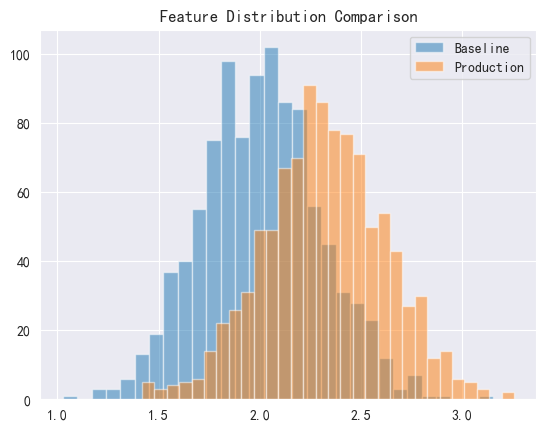

In [10]:

import numpy as np
import matplotlib.pyplot as plt

def ecdf(sample):
    xs = np.sort(sample)
    ys = np.arange(1, len(xs)+1) / float(len(xs))
    return xs, ys

def ks_2samp_numpy(x, y):
    xs_x, ys_x = ecdf(x)
    xs_y, ys_y = ecdf(y)
    all_points = np.sort(np.unique(np.concatenate([xs_x, xs_y])))
    # CDF values at all_points
    Fx = np.searchsorted(xs_x, all_points, side='right') / float(len(xs_x))
    Fy = np.searchsorted(xs_y, all_points, side='right') / float(len(xs_y))
    d_stat = np.max(np.abs(Fx - Fy))
    return d_stat

def psi(expected, actual, bins=10):
    hist_e, edges = np.histogram(expected, bins=bins)
    hist_a, _     = np.histogram(actual,   bins=edges)
    pe = hist_e / np.maximum(len(expected), 1)
    pa = hist_a / np.maximum(len(actual),   1)
    pe = np.where(pe==0, 1e-6, pe)
    pa = np.where(pa==0, 1e-6, pa)
    return float(np.sum((pe - pa) * np.log(pe / pa)))

np.random.seed(42)
baseline = np.random.normal(2.0, 0.3, 1000)
production = np.random.normal(2.3, 0.3, 1000)

ks_d = ks_2samp_numpy(baseline, production)
psi_v = psi(baseline, production)

print("KS 距离：", round(ks_d, 4))
print("PSI：", round(psi_v, 4), "(>0.1 需关注)")

plt.hist(baseline, bins=30, alpha=0.5, label='Baseline')
plt.hist(production, bins=30, alpha=0.5, label='Production')
plt.legend(); plt.title('Feature Distribution Comparison'); plt.show()


## 7. 再训练编排：基于阈值的触发示例

In [11]:

from sklearn.metrics import accuracy_score
import torch

def evaluate_acc(model, loader):
    model.eval()
    preds, tars = [], []
    with torch.no_grad():
        for xb, yb in loader:
            p = (torch.sigmoid(model(xb)) > 0.5).int()
            preds.extend(p.tolist()); tars.extend(yb.tolist())
    return accuracy_score(tars, preds)

# 使用先前最佳模型与验证集模拟“新数据表现”
val_acc = evaluate_acc(best_model, val_dl)
print("验证集准确率：", round(val_acc,4))

if val_acc < 0.85:
    print("触发再训练：")
    re_model = MLP(X.shape[1], h, d)
    opt = optim.Adam(re_model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    for _ in range(10):
        re_model.train()
        for xb, yb in train_dl:
            opt.zero_grad()
            logits = re_model(xb)
            loss = criterion(logits, yb.float())
            loss.backward(); opt.step()
    new_acc = evaluate_acc(re_model, val_dl)
    print("再训练完成，新验证准确率：", round(new_acc,4))
else:
    print("性能达标，无需再训练。")


验证集准确率： 0.92
性能达标，无需再训练。


## 8. A/B 测试：两模型在线分流评估（模拟）

In [12]:

import random
import torch

# 构造另一份结构略不同的模型B（随机初始化，示例）
model_b = MLP(X.shape[1], max(16, h//2), d)

# 用同一个验证集进行分流
pairs = list(zip(torch.tensor(X_va), torch.tensor(y_va)))
random.seed(123)
p = 0.5  # A/B 50% 分流
preds_a, preds_b, tars_a, tars_b = [], [], [], []

for xb, yb in pairs:
    route_a = random.random() < p
    if route_a:
        with torch.no_grad():
            pa = (torch.sigmoid(best_model(xb.unsqueeze(0))) > 0.5).int().item()
        preds_a.append(pa); tars_a.append(int(yb.item()))
    else:
        with torch.no_grad():
            pb = (torch.sigmoid(model_b(xb.unsqueeze(0))) > 0.5).int().item()
        preds_b.append(pb); tars_b.append(int(yb.item()))

acc_a = accuracy_score(tars_a, preds_a) if tars_a else 0.0
acc_b = accuracy_score(tars_b, preds_b) if tars_b else 0.0
print(f"A 组样本 {len(tars_a)}，准确率：{round(acc_a,4)}")
print(f"B 组样本 {len(tars_b)}，准确率：{round(acc_b,4)}")


A 组样本 306，准确率：0.9314
B 组样本 294，准确率：0.5306
